In [61]:
#https://keras.io/examples/timeseries/timeseries_classification_transformer/

In [62]:
import numpy as np
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical

In [63]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [65]:
file = open('D:/HAR/WISDM/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [66]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [67]:
data = pd.DataFrame(data = processedList, columns = columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [68]:
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

In [69]:
df = data.drop(['user', 'time'], axis = 1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [70]:
Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].copy()

In [71]:
import pandas as pd

balanced_data = pd.DataFrame()
balanced_data = pd.concat([balanced_data, Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(21330, 4)

In [72]:
balanced_data['activity'].value_counts()

activity
Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: count, dtype: int64

In [73]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [74]:
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

In [75]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


In [76]:
import scipy.stats as stats

In [77]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [78]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [79]:
X, y = get_frames(scaled_X, frame_size, hop_size)

<ipython-input-78-351285eacf6e>:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


In [80]:
X.shape, y.shape

((532, 80, 3), (532,))

In [81]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [82]:
x_train.shape, x_test.shape

((425, 80, 3), (107, 80, 3))

In [83]:
#x_train = x_train.reshape(425, 80, 3, 1)
#x_test = x_test.reshape(107, 80, 3, 1)

In [84]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((425, 80, 3), (425,), (107, 80, 3), (107,))

In [85]:
n_classes = 6

In [96]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [87]:
"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)



In [88]:
"""
## Train and evaluate
"""

input_shape = Input(shape=(n_timesteps,n_features))

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    #loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    #metrics=["sparse_categorical_accuracy"],
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 80, 3)]              0         []                            
                                                                                                  
 multi_head_attention_12 (M  (None, 80, 3)                15363     ['input_4[0][0]',             
 ultiHeadAttention)                                                  'input_4[0][0]']             
                                                                                                  
 dropout_24 (Dropout)        (None, 80, 3)                0         ['multi_head_attention_12[0][0
                                                                    ]']                           
                                                                                              

 dropout_29 (Dropout)        (None, 80, 4)                0         ['conv1d_28[0][0]']           
                                                                                                  
 conv1d_29 (Conv1D)          (None, 80, 3)                15        ['dropout_29[0][0]']          
                                                                                                  
 layer_normalization_29 (La  (None, 80, 3)                6         ['conv1d_29[0][0]']           
 yerNormalization)                                                                                
                                                                                                  
 tf.__operators__.add_29 (T  (None, 80, 3)                0         ['layer_normalization_29[0][0]
 FOpLambda)                                                         ',                            
                                                                     'tf.__operators__.add_28[0][0
          

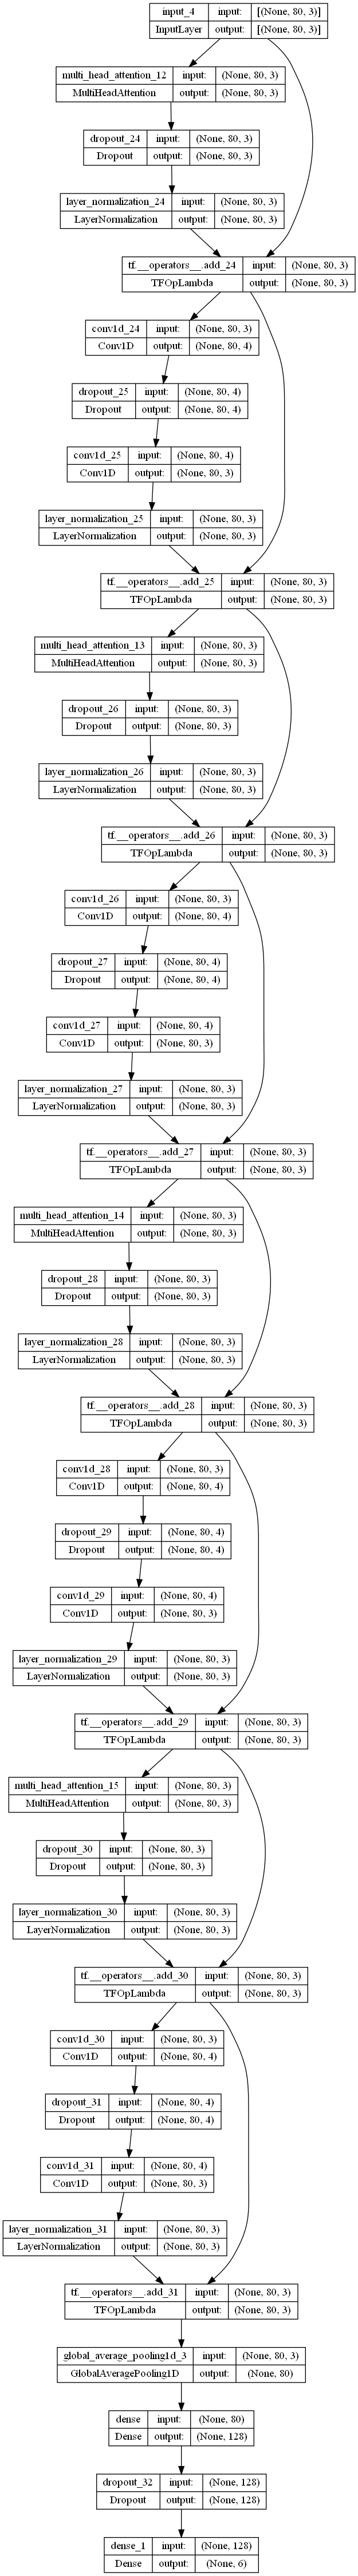

In [89]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [90]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/300
6/6 [==============================] - 15s 2s/step - loss: 2.1539 - accuracy: 0.1412 - val_loss: 2.1029 - val_accuracy: 0.1529
Epoch 2/300
6/6 [==============================] - 8s 1s/step - loss: 2.1224 - accuracy: 0.1588 - val_loss: 2.0479 - val_accuracy: 0.1529
Epoch 3/300
6/6 [==============================] - 8s 1s/step - loss: 2.0569 - accuracy: 0.2176 - val_loss: 1.9922 - val_accuracy: 0.1647
Epoch 4/300
6/6 [==============================] - 8s 1s/step - loss: 2.0379 - accuracy: 0.1824 - val_loss: 1.9398 - val_accuracy: 0.1647
Epoch 5/300
6/6 [==============================] - 8s 1s/step - loss: 2.0011 - accuracy: 0.2235 - val_loss: 1.8905 - val_accuracy: 0.1765
Epoch 6/300
6/6 [==============================] - 8s 1s/step - loss: 1.8894 - accuracy: 0.2147 - val_loss: 1.8423 - val_accuracy: 0.1765
Epoch 7/300
6/6 [==============================] - 8s 1s/step - loss: 1.9103 - accuracy: 0.1971 - val_loss: 1.7949 - val_accuracy: 0.1882
Epoch 8/300
6/6 [================

Epoch 60/300
6/6 [==============================] - 10s 2s/step - loss: 1.1683 - accuracy: 0.5912 - val_loss: 1.2384 - val_accuracy: 0.5294
Epoch 61/300
6/6 [==============================] - 9s 1s/step - loss: 1.1681 - accuracy: 0.5765 - val_loss: 1.2292 - val_accuracy: 0.5294
Epoch 62/300
6/6 [==============================] - 9s 2s/step - loss: 1.1891 - accuracy: 0.5235 - val_loss: 1.2191 - val_accuracy: 0.5294
Epoch 63/300
6/6 [==============================] - 9s 1s/step - loss: 1.1579 - accuracy: 0.5765 - val_loss: 1.2075 - val_accuracy: 0.5294
Epoch 64/300
6/6 [==============================] - 9s 1s/step - loss: 1.1929 - accuracy: 0.5647 - val_loss: 1.1991 - val_accuracy: 0.5529
Epoch 65/300
6/6 [==============================] - 9s 1s/step - loss: 1.1310 - accuracy: 0.6000 - val_loss: 1.1915 - val_accuracy: 0.5529
Epoch 66/300
6/6 [==============================] - 9s 1s/step - loss: 1.1534 - accuracy: 0.5676 - val_loss: 1.1864 - val_accuracy: 0.5529
Epoch 67/300
6/6 [========

Epoch 119/300
6/6 [==============================] - 9s 1s/step - loss: 0.8870 - accuracy: 0.6941 - val_loss: 1.0089 - val_accuracy: 0.5882
Epoch 120/300
6/6 [==============================] - 8s 1s/step - loss: 0.8613 - accuracy: 0.7412 - val_loss: 1.0054 - val_accuracy: 0.6000
Epoch 121/300
6/6 [==============================] - 8s 1s/step - loss: 0.8968 - accuracy: 0.6735 - val_loss: 1.0019 - val_accuracy: 0.6000
Epoch 122/300
6/6 [==============================] - 8s 1s/step - loss: 0.8708 - accuracy: 0.7235 - val_loss: 0.9999 - val_accuracy: 0.6000
Epoch 123/300
6/6 [==============================] - 8s 1s/step - loss: 0.8480 - accuracy: 0.6912 - val_loss: 0.9990 - val_accuracy: 0.5882
Epoch 124/300
6/6 [==============================] - 8s 1s/step - loss: 0.8459 - accuracy: 0.7206 - val_loss: 0.9956 - val_accuracy: 0.5882
Epoch 125/300
6/6 [==============================] - 8s 1s/step - loss: 0.8522 - accuracy: 0.7206 - val_loss: 0.9994 - val_accuracy: 0.5882
Epoch 126/300
6/6 [=

6/6 [==============================] - 9s 1s/step - loss: 0.5939 - accuracy: 0.8147 - val_loss: 0.8652 - val_accuracy: 0.6706
Epoch 236/300
6/6 [==============================] - 8s 1s/step - loss: 0.5622 - accuracy: 0.8441 - val_loss: 0.8643 - val_accuracy: 0.6706
Epoch 237/300
6/6 [==============================] - 10s 2s/step - loss: 0.5740 - accuracy: 0.8324 - val_loss: 0.8621 - val_accuracy: 0.6588
Epoch 238/300
6/6 [==============================] - 9s 1s/step - loss: 0.5722 - accuracy: 0.8324 - val_loss: 0.8634 - val_accuracy: 0.6706
Epoch 239/300
6/6 [==============================] - 9s 1s/step - loss: 0.5663 - accuracy: 0.8529 - val_loss: 0.8641 - val_accuracy: 0.6706
Epoch 240/300
6/6 [==============================] - 9s 1s/step - loss: 0.5787 - accuracy: 0.8265 - val_loss: 0.8616 - val_accuracy: 0.6588
Epoch 241/300
6/6 [==============================] - 9s 1s/step - loss: 0.5324 - accuracy: 0.8735 - val_loss: 0.8602 - val_accuracy: 0.6588
Epoch 242/300
6/6 [==============

[0.7035793662071228, 0.7102803587913513]

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracys')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

4/4 [==============================] - 1s 208ms/step


(<Figure size 504x504 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

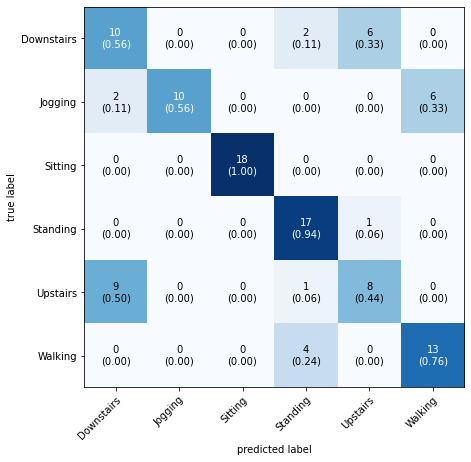

In [94]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

predict_x = model.predict(x_test) 
y_pred_class= np.argmax(predict_x,axis=1)
mat = confusion_matrix(y_test, y_pred_class)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [95]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(accuracy_score(y_test,y_pred_class))
print(classification_report(y_test,y_pred_class))

0.7102803738317757
              precision    recall  f1-score   support

           0       0.48      0.56      0.51        18
           1       1.00      0.56      0.71        18
           2       1.00      1.00      1.00        18
           3       0.71      0.94      0.81        18
           4       0.53      0.44      0.48        18
           5       0.68      0.76      0.72        17

    accuracy                           0.71       107
   macro avg       0.73      0.71      0.71       107
weighted avg       0.73      0.71      0.71       107

